*Universidad de Chile*  
*Facultad de Ciencias Físicas y Matemáticas*  
*Departamento de Ingeniería Matemática*
 
# Laboratorio 3
**Curso:** MA4703-1 Control Óptimo: Teoría y Laboratorio  
**Profesor:** Héctor Ramírez C.  
**Auxiliares:** Javier Madariaga R. y Pablo Araya Z.   
**Alumno:** Diego Dominguez - Arturo Lazcano

In [1]:
import numpy as np
from control import ctrb, obsv, gram, StateSpace, lqr, place
from scipy.integrate import solve_ivp
from scipy.optimize import linprog, minimize, fsolve
import matplotlib.pyplot as plt
import time
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

## P1

El sistema original del circuito es:
\begin{align*}
    L_1\frac{di_i}{dt}(t)+K\frac{di_2}{dt}(t) +R_ci_1(t) &=u(t) \\
    K\frac{di_i}{dt}(t)+L_2\frac{di_2}{dt}(t) +R_wi_2(t) &=0 \\
    i_1(0) &= -i_0 \\
    i_2(0) &= 0 \\
    u(t) &\in [-a,a]  ~ \forall t \geq 0
\end{align*}
Las primeras dos ecuaciones de este sistema equivalen a:
\begin{align*}
    L_1i_1' + Ki_2' +R_ci_1 &= u \\
    Ki_1' + L_2x_2' R_wi_2 &= 0
\end{align*}
Luego,
\begin{align*}
    i_1' &= \frac{u-Ki_2'-R_ci_1}{L_1} = \frac{-L_2i_2' - R_wi_2}{L_2} \\
    i_2' &= \frac{u-L_1i_1'-R_ci_1}{K} = \frac{-Ki_1' - R_wi_2}{L_2}
\end{align*}
Por lo que reemplazando $i_2$ en la primera ecuación e $i_1$ en la segunda resulta:
\begin{equation*}
    i_1' = \frac{L_2u + K^2i_1' + KR_wi_2 - R_cL_2i_1}{L_1L_2} ; \quad i_2' = \frac{uK + L_1L_2i_2' + L_1R_wi_2 - R_cKi_1}{K^2}
\end{equation*}
Así,
\begin{align*}
    i_1' (L_1L_2-K^2) &= L_2u + KR_wi_2 - R_cL_2i_1 \\
    i_2' (K^2-L_1L_2) &= uK+L_1R_wi_2 - R_cKi_1
\end{align*}
Por último, multiplicando la segunda ecuación por -1 nos queda el siguiente sistema matricial:
\begin{equation*}
    \begin{pmatrix} i_1' \\ i_2' \end{pmatrix} = \frac{1}{(1-\alpha^2)L_1L_2} \begin{pmatrix} -L_2R_C & \alpha \sqrt{L_1L_2}R_w \\ \alpha \sqrt{L_1L_2}R_c & -L_1R_w \end{pmatrix} \begin{pmatrix}i_1 \\ i_2 \end{pmatrix} +  \frac{1}{(1-\alpha^2)L_1L_2} \begin{pmatrix} L_2 \\ -K \end{pmatrix}u(t)
\end{equation*}

## P2

In [2]:
#Parametros iniciales
i0=1 
L1=3.5 
L2=2 
Rc=1 
Rw=3 
alpha=0.9 
a=50 
K=alpha*np.sqrt(L1*L2) 
M=1/((1-alpha**2)*L1*L2)

In [3]:
#Matrices del sistema
A=M*np.array([[-L2*Rc, alpha*np.sqrt(L1*L2)*Rw],
              [alpha*np.sqrt(L1*L2)*Rc, -L1*Rw ]])
B=M*np.array([[L2], [-K]]) 
print(A) 
print(B)

[[-1.5037594   5.37107409]
 [ 1.79035803 -7.89473684]]
[[ 1.5037594 ]
 [-1.79035803]]


In [4]:
Kalman_matrix=ctrb(A,B)
print(Kalman_matrix)
print("Rango de la matriz de Kalman:", np.linalg.matrix_rank(Kalman_matrix))

[[  1.5037594  -11.87743796]
 [ -1.79035803  16.82667321]]
Rango de la matriz de Kalman: 2


La matriz de Kalman obtenida es de rango completo, pues las dos columnas obtenidas son linealmente independientes entre sí.

## P3

In [5]:
#Esta función crea una función de control constante con x la cte que queremos utilizar
def control_cte(x):
    U=lambda t: [x]
    return U

#Recibe una funcion y retorna un sistema correspondiente a la dinamica del problema
#considerando la funcion recibida. 
def sistema_cte(U):
    sistema = lambda t, x: np.matmul(A,x) + np.matmul(B,U(t)) 
    return sistema

In [6]:
#Se crea los controles constantes y se resuelve el sistema por cada control creado.
cond_inicial=[-i0,0] 
cte_controles=[-100,0.5,100]
controles=[]
sistemas=[]
soluciones=[]
sol_tiempos=[]

j=0
for cte in cte_controles:
    controles.append(control_cte(cte))
    sistemas.append(sistema_cte(controles[j]))
    sol=solve_ivp(fun=sistemas[j], t_span=[0,100], y0=cond_inicial, dense_output=True)
    sol_tiempos.append(sol.t)
    L=len(sol.t)
    I=np.zeros((L,2), dtype='object')
    for t in range(L):
        i1_t=sol.y[0][t]
        i2_t=sol.y[1][t]
        I[t,:]=sistemas[j](sol.t[t], [i1_t, i2_t])

    I1=I[:,0]
    I2=I[:,1]
    soluciones.append([I1,I2])
    j+=1

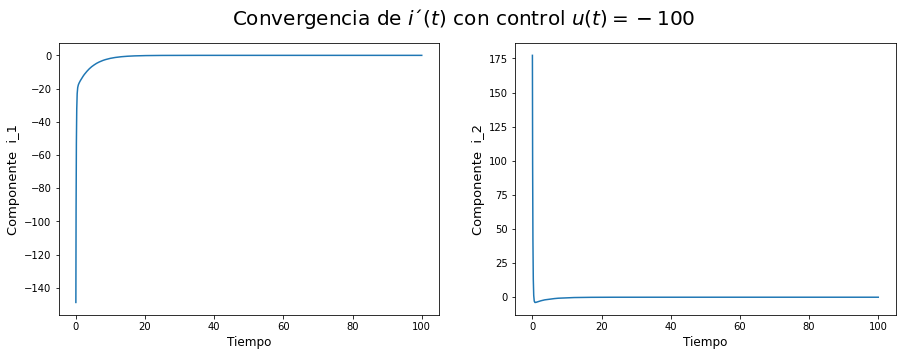

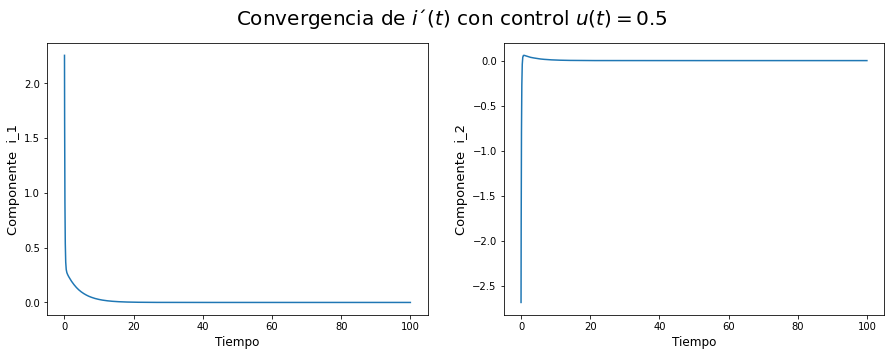

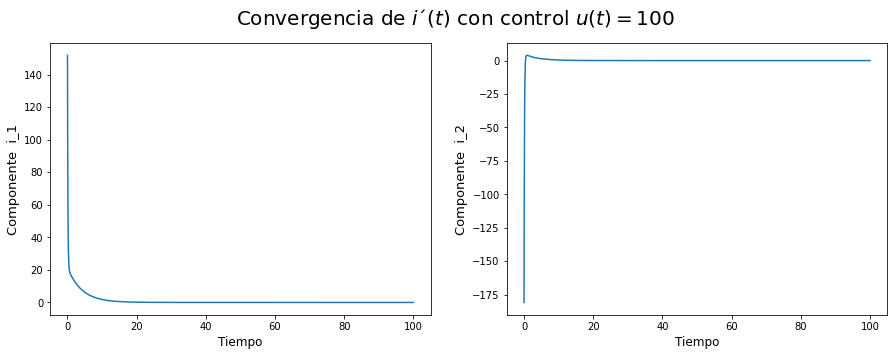

In [7]:
#Grafico de i'(t)
for j in range(len(controles)):
    fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize=(15,5))
    fig.suptitle(f'Convergencia de $i´(t)$ con control $u(t)={cte_controles[j]}$', fontsize=20)
    for i, ax in enumerate(axs):
        ax.set_xlabel('Tiempo', fontsize=12)
        ax.set_ylabel(f'Componente  i_{i+1}', fontsize=13)
        ax.plot(sol_tiempos[j], soluciones[j][i])
    plt.show()

## P4

\begin{equation}
\begin{array}
\displaystyle \min_{u} & T\\
\textrm{s.a.} & i_1' = \frac{1}{(1-\alpha ^2)L_1 L_2}(-L_2 R_c i_1 + \alpha \sqrt{L_1 L_2} R_w i_2 +L_2 u) \\
&   i_2' = \frac{1}{(1-\alpha ^2)L_1 L_2}(\alpha \sqrt{L_1 L_2}R_ci_1 - L_1 R_w i_2 - Ku) \\
& (i_1 (0), i_2 (0))=(-i_0, 0)\\
& (i_1 (T), i_2 (T))=(i_0, 0)\\
&|u(\cdot)|\leq a
\end{array}
\end{equation}

Considerando  $i_0$ = 1, $L_1$ = 3.5, $L_2$ = 2, $R_c$ = 1, $R_w$ = 3, $α$ = 0.9, y $a$ = 50

## P5

In [8]:
def funcionObjetivo(parametros):
    u=parametros[:N]
    t=parametros[-1]
    return t

def restriccion1(parametros):
    u=parametros[:N]
    t=parametros[-1]
    i1=np.zeros(N)
    i2=np.zeros(N)
    i1[0]=-i0
    i2[0]=0
    #Metodo de discretización de Euler
    delta_t= t/N
    for k in range(N-1):
        i1[k+1]=i1[k]+delta_t*M*(-L2*Rc*i1[k] + K*Rw*i2[k] +L2*u[k])
        i2[k+1]=i2[k]+delta_t*M*(K*Rc*i1[k] - L1*Rw*i2[k] - K*u[k])
    restriccion=i1[-1]-i0 #La posición final de componente i_1 debe ser igual a i0
    return restriccion
    
def restriccion2(parametros):
    u=parametros[:N]
    t=parametros[-1]
    i1=np.zeros(N)
    i2=np.zeros(N)
    i1[0]=-i0
    i2[0]=0
    #Metodo de discretización de Euler
    delta_t= t/N
    for k in range(N-1):
        i1[k+1]=i1[k]+delta_t*M*(-L2*Rc*i1[k] + K*Rw*i2[k] +L2*u[k])
        i2[k+1]=i2[k]+delta_t*M*(K*Rc*i1[k] - L1*Rw*i2[k] - K*u[k])
    restriccion=i2[-1]-0 #La posición final de componente i_2 debe ser igual a 0
    return restriccion

#Restricciones auxiliares
restriccion3=lambda parametros: -restriccion1(parametros)
restriccion4=lambda parametros: -restriccion2(parametros)

In [9]:
def solucion_optima(N, metodo, u0, t0):
    cotas = [(-a,a)]*N + [(0,None)]
    #El metodo de optimizacion COBYLA no recibe restricciones de iguladad, 
    #por lo que se usará inecuaciones usando las restricciones auxiliares.
    if metodo=='COBYLA':
        restricciones = [{'type':'ineq','fun': restriccion1},{'type':'ineq','fun': restriccion2},
                         {'type':'ineq','fun': restriccion3},{'type':'ineq','fun': restriccion4}]
    else: 
        restricciones = [{'type':'eq','fun': restriccion1},{'type':'eq','fun': restriccion2}]
    initial=np.concatenate((u0,t0))
    #Optimización del problema
    sol = minimize(funcionObjetivo, initial, bounds = cotas, constraints = restricciones, method=metodo)
    u=sol.x[:N] #control optimo
    t_= sol.x[-1] #tiempo minimo
    #Cálculo de la trayectoria de la corriente eléctrica. 
    i1=np.zeros(N)
    i2=np.zeros(N)
    i1[0]=-i0
    i2[0]=0
    delta_t=t_/N
    for k in range(N-1):
        i1[k+1]=i1[k]+delta_t*M*(-L2*Rc*i1[k] + K*Rw*i2[k] +L2*u[k])
        i2[k+1]=i2[k]+delta_t*M*(K*Rc*i1[k] - L1*Rw*i2[k] - K*u[k])
    
    #Grafico de las soluciones obtenidas
    t = [t_*i/N for i in range(N)]
    funciones = [i1, i2, u]
    funciones = [[i1,i2],[u,0]]
    ejes=[['i_1(t)','i_2(t)'],['u(t)',0]]
    fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize=(15,10))
    fig.subplots_adjust(top=0.95, hspace=0.3) 
    fig.suptitle(f'Trayectorias con N={N}, $t_f$ =' + str(t[-1])[:5]+r', $t_{f0}=$'+f'{t0[0]}, '+r'$\vec{u}_0=$'+f'{int(u0[-1])} y método {metodo}', y=1.03, fontsize=20)
    k=0
    for i, row in enumerate(axs):
        for j, ax in enumerate(row):
            if i==j==1:
                axs[i,j].set_ylabel(r'$i_2(t)$', fontsize=12)
                axs[i,j].set_xlabel(r'$i_1(t)$', fontsize=12)
                axs[i,j].plot(i1,i2)
                axs[i,j].scatter(i1[-1],i2[-1],label=f'{np.round(i1[-1],3),np.round(i2[-1],3)}',color='darkorange')
                axs[i,j].legend()
                axs[i,j].set_title(r'Corrriente eléctrica i(t)')
            else:
                axs[i,j].set_ylabel(f'${ejes[i][j]}$', fontsize=12)
                axs[i,j].set_xlabel('Tiempo t', fontsize=12)
                axs[i,j].plot(t, funciones[i][j])
                axs[i,j].plot(t[-1],funciones[i][j][-1],'o',label=str(np.round(funciones[i][j][-1],5)))
                axs[i,j].legend()
                axs[i,j].set_title(f'Función ${ejes[i][j]}$ a tráves del tiempo')
    plt.show()

## P6

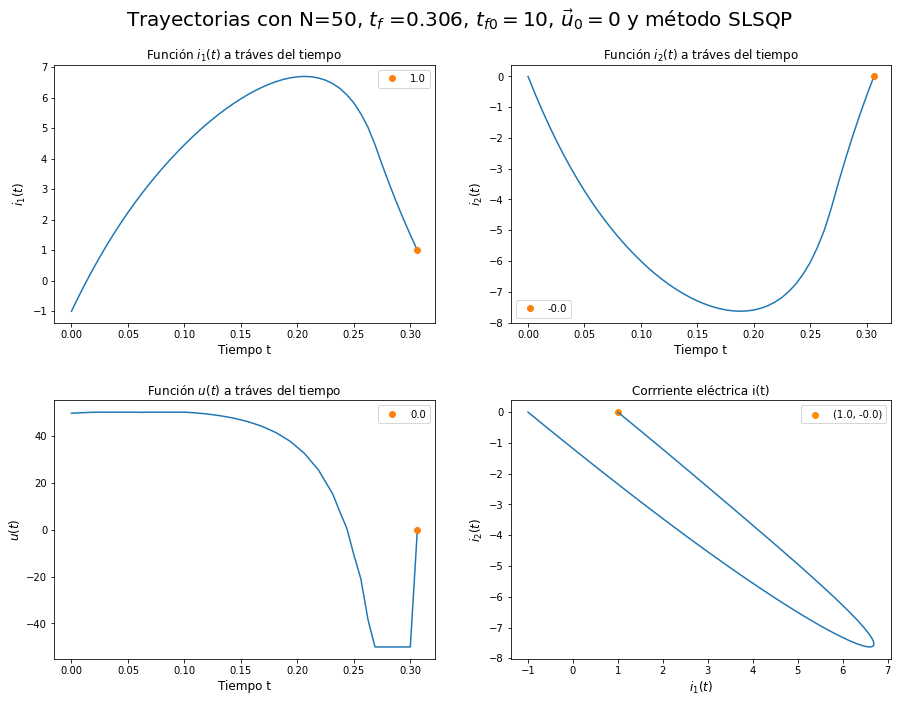

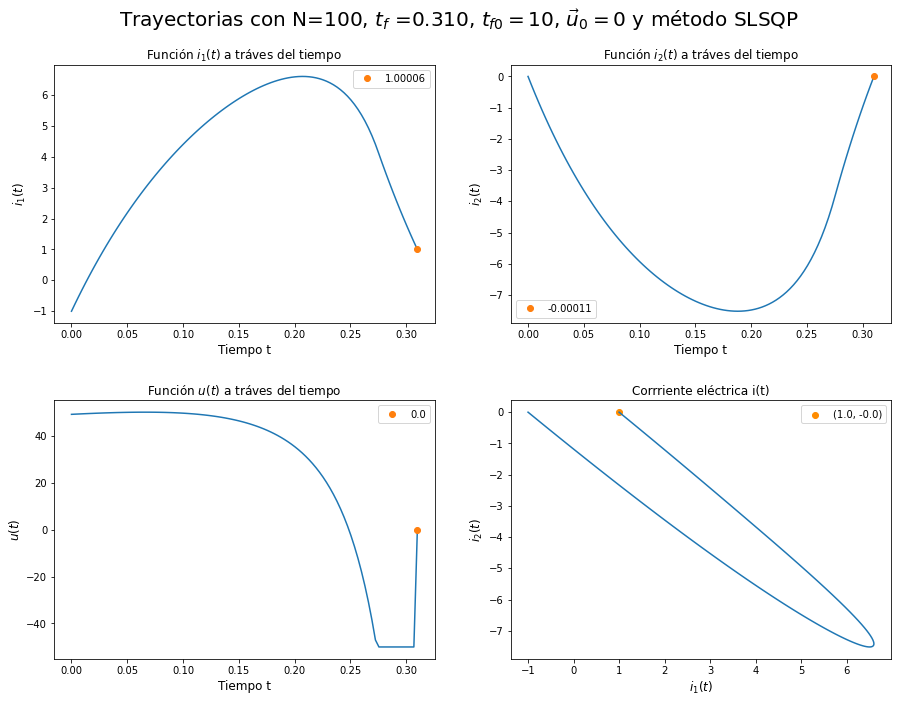

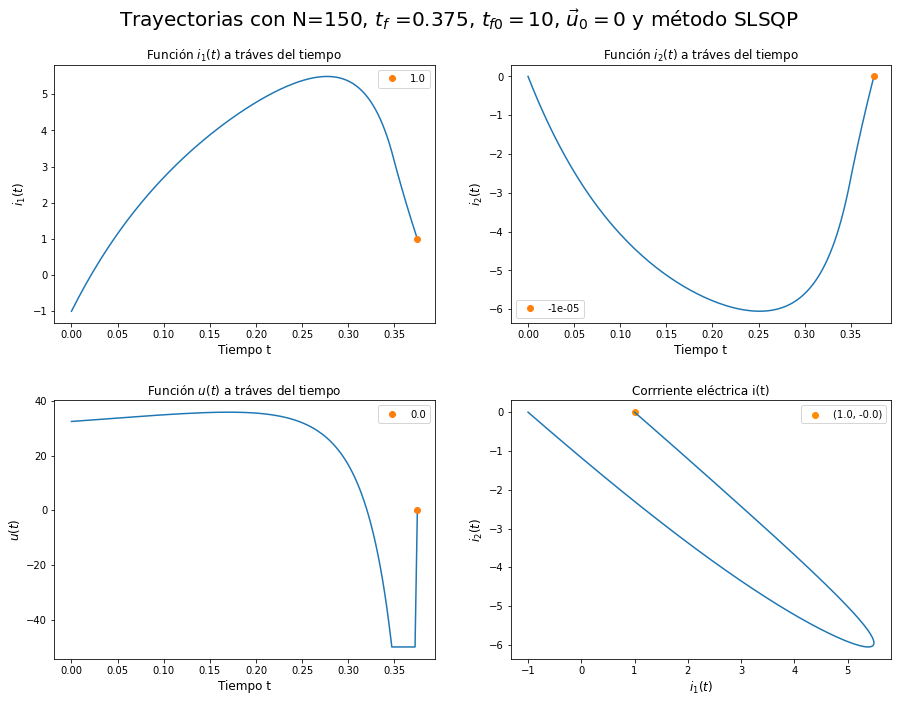

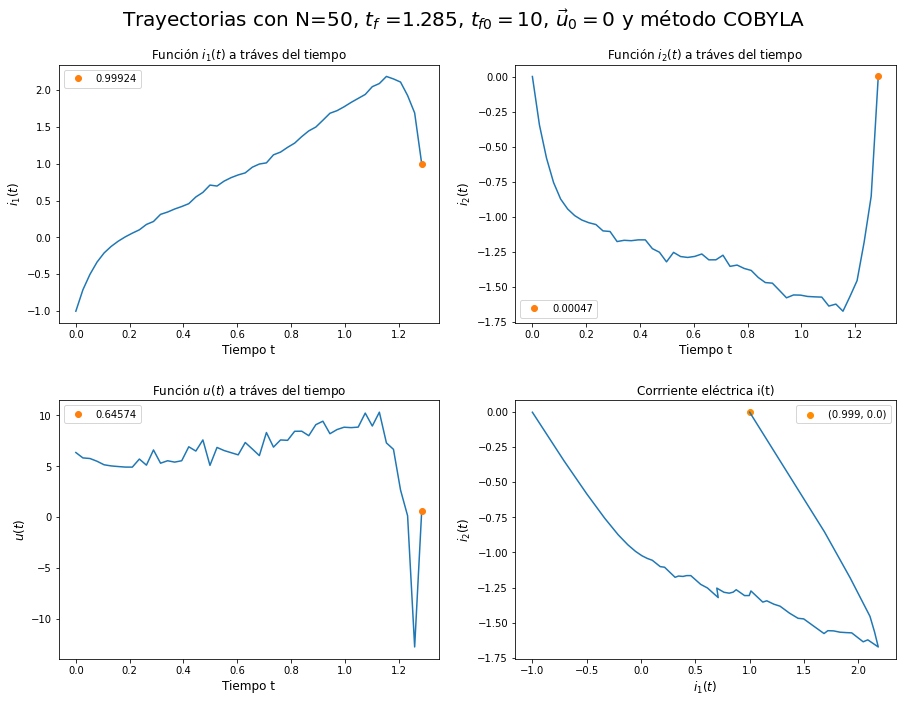

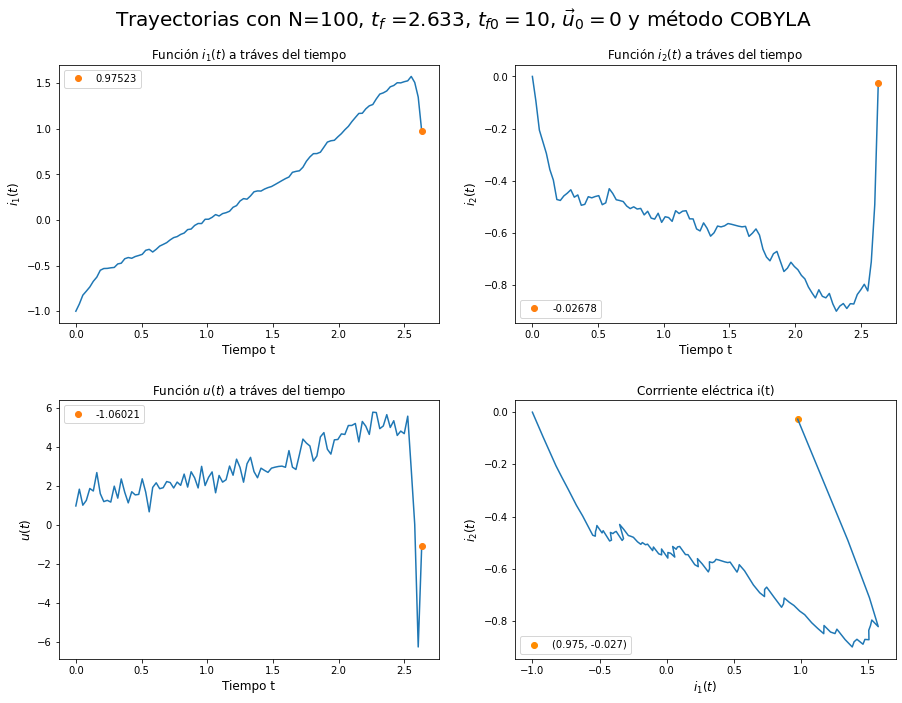

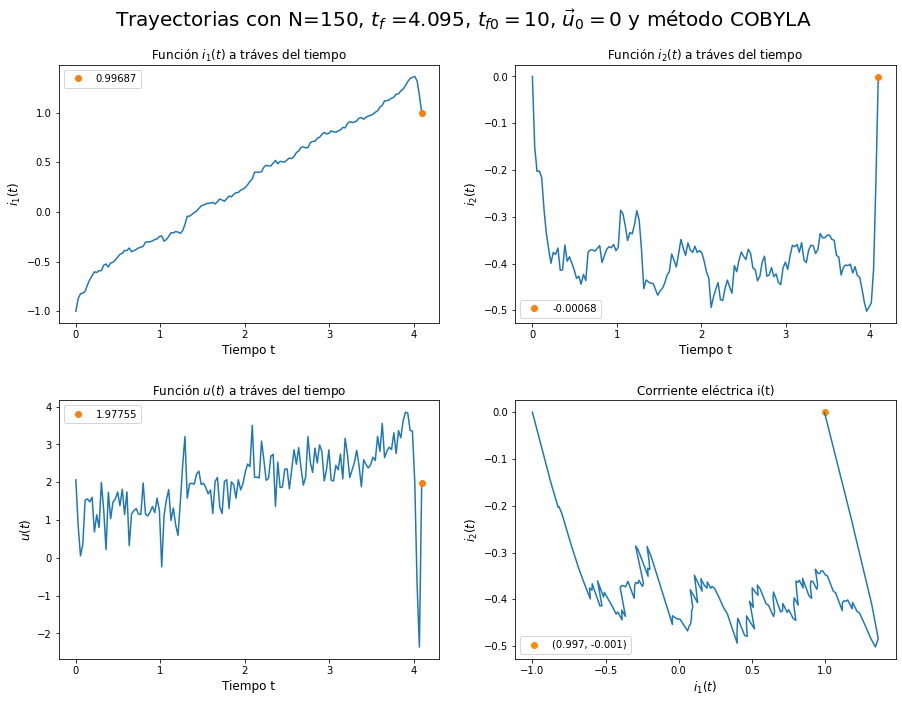

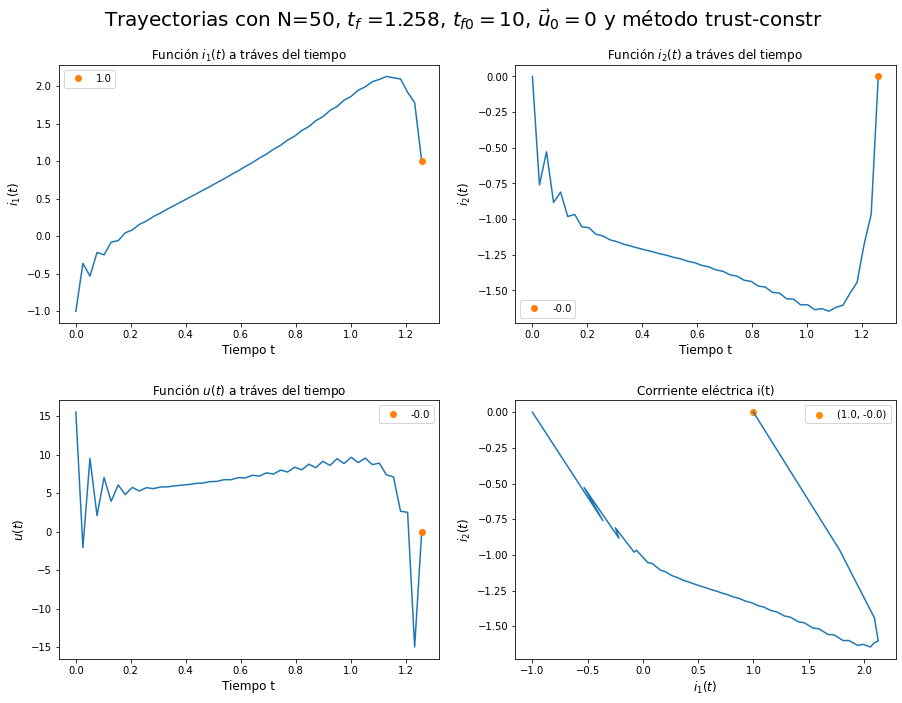

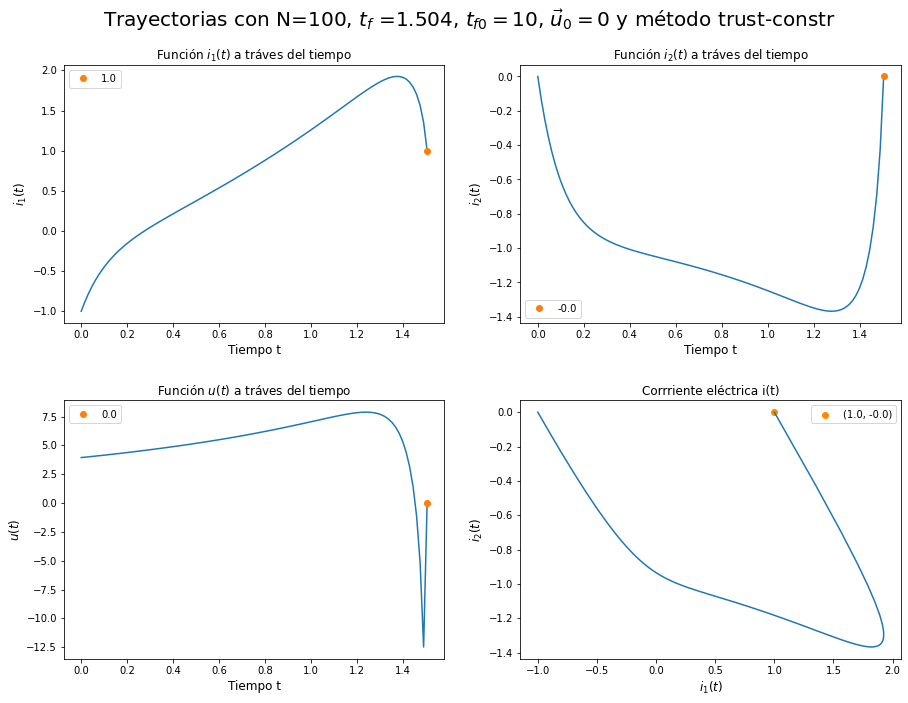

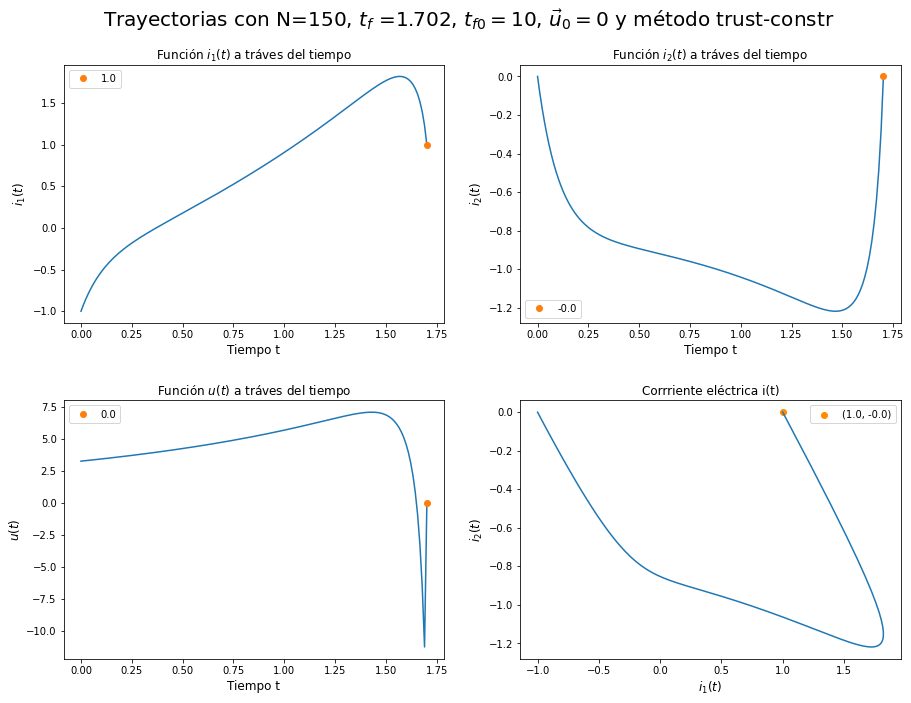

In [10]:
#Variacion de los méotodos y los valores de N
Metodos=['SLSQP', 'COBYLA', 'trust-constr']
Ns=[50,100,150]
tiempos={}
for metodo in Metodos:
    for N in Ns:
        u0 = np.zeros(N)
        t0 = np.array([10])
        t0_ejec=time.time()
        solucion_optima(N, metodo, u0, t0)
        t_ejec=time.time()-t0_ejec
        tiempos[(metodo, N)]=t_ejec

Se observa que para el método $\texttt{SLSQP}$ basta 50 iteraciones para obtener trayectorias suaves tanto para la corriente como para el control, por lo que con $N=150$ se obtiene resultados muy similares. Por otro lado, con el método $\texttt{COBYLA}$ se observa que valor objetivo empeora a medida que aumenta $N$. Por último, el método $\texttt{trust-constr}$ entrega soluciones con muy poco ruido con $N=50$, y el resultado mejora cuando $N$ aumenta. Aún así, el tiempo final obtenido es mayor al que entrega $\texttt{SLSQP}$, por lo tanto, para un $t_0 = 0$ y $(u_{0}(j))_{j=1}^N=\vec{0}$, se concluye que el tiempo mínimo es $0.3$. 

In [11]:
#Complejidad de los tiempos de ejecución
df=pd.DataFrame(columns=['N']+Metodos)
df['N']=Ns
df=df.set_index('N')

for metodo in Metodos:
    for N in Ns:
        df.loc[N,metodo]=tiempos[(metodo,N)]

styles = [dict(selector="caption", props=[("text-align", "center"), ("font-size", "120%"),("font-weight", "bold"),("color", 'black')])]
df=df.style.set_caption('Tiempos de ejecución').set_table_styles(styles)
df

,SLSQP,COBYLA,trust-constr
N,,,
50,2.111617,1.193823,25.408998
100,6.214579,2.542978,74.134039
150,13.201498,5.257942,153.268750


Notemos que el tiempo de ejecución del problema de minimización crece a medida que aumenta la cantidad de puntos discretizados $N$. De hecho se observa que por cada 50 discretizaciones extras, el tiempo de ejecución tienede a duplicarse. 

Así que para los experimentos siguientes se fija $N=150$ y se utilizará el método $\texttt{SLSQP}$, pues con estos paramétros se obtuvo la mejor solución en el menor tiempo de ejecución. 

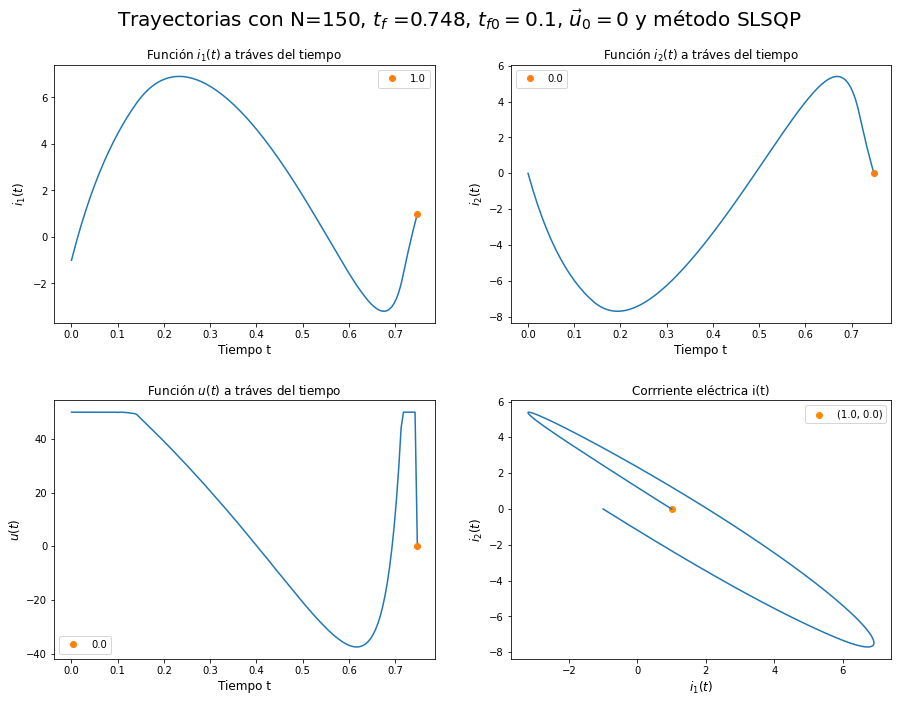

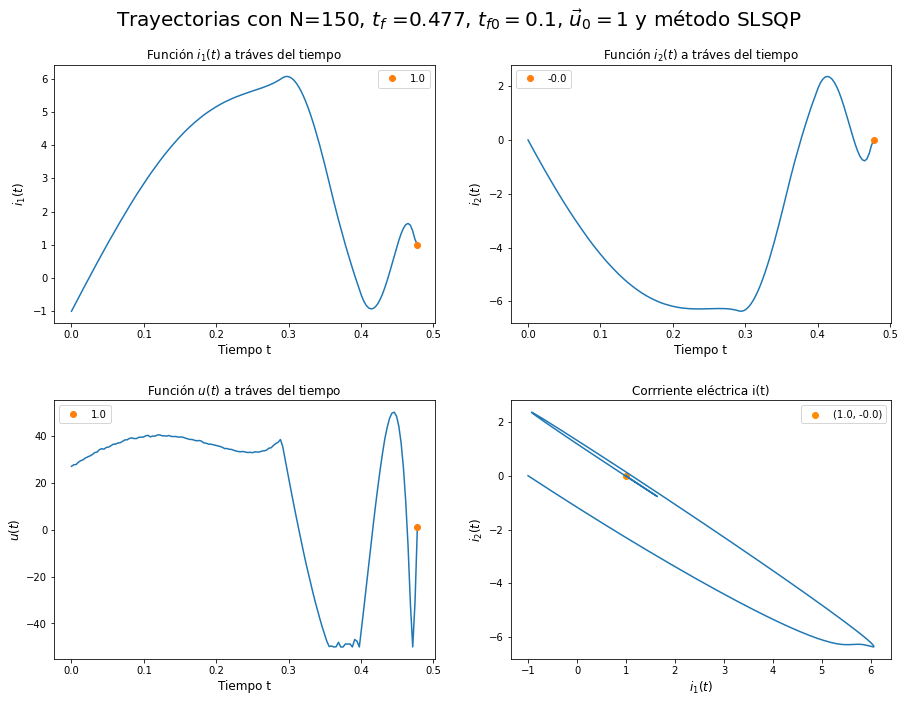

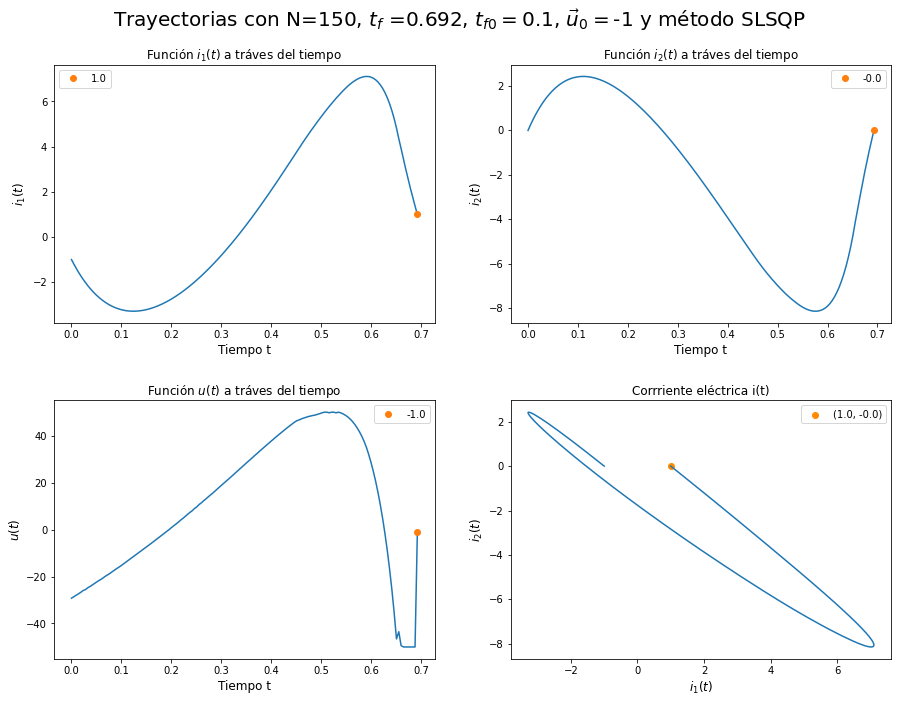

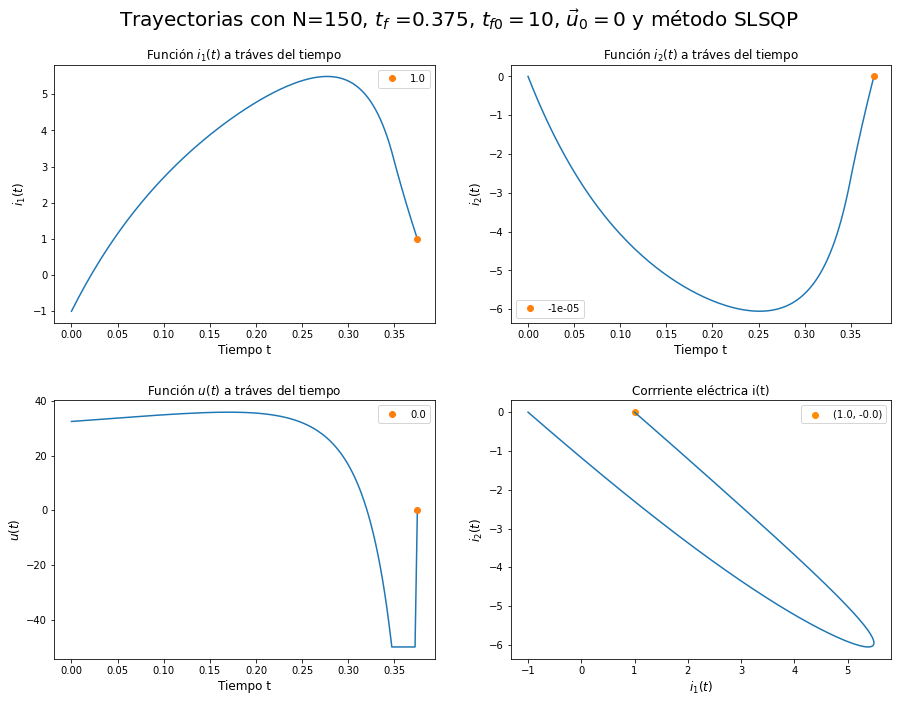

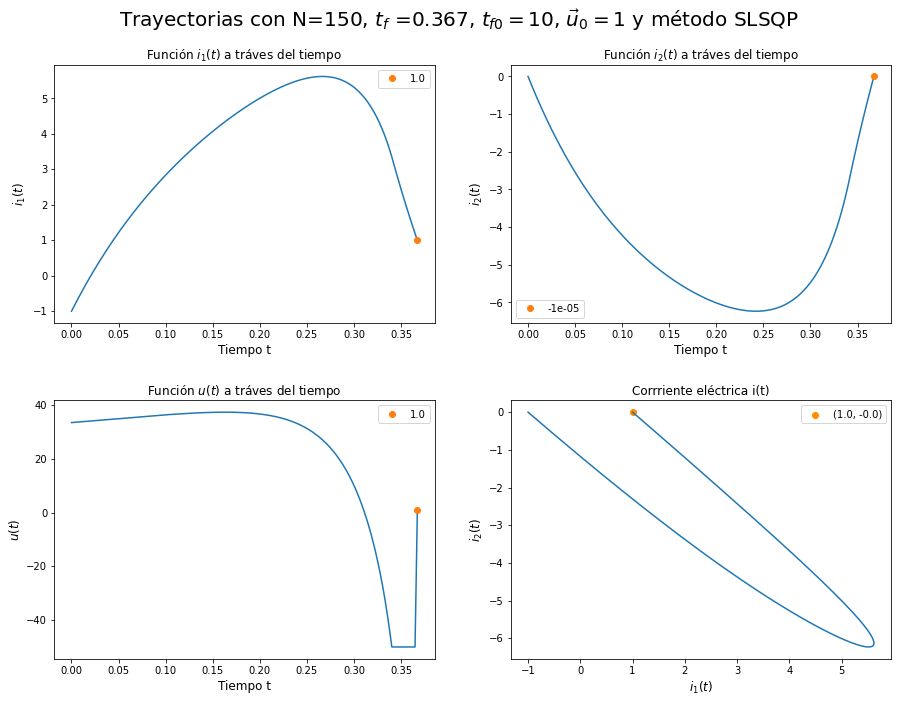

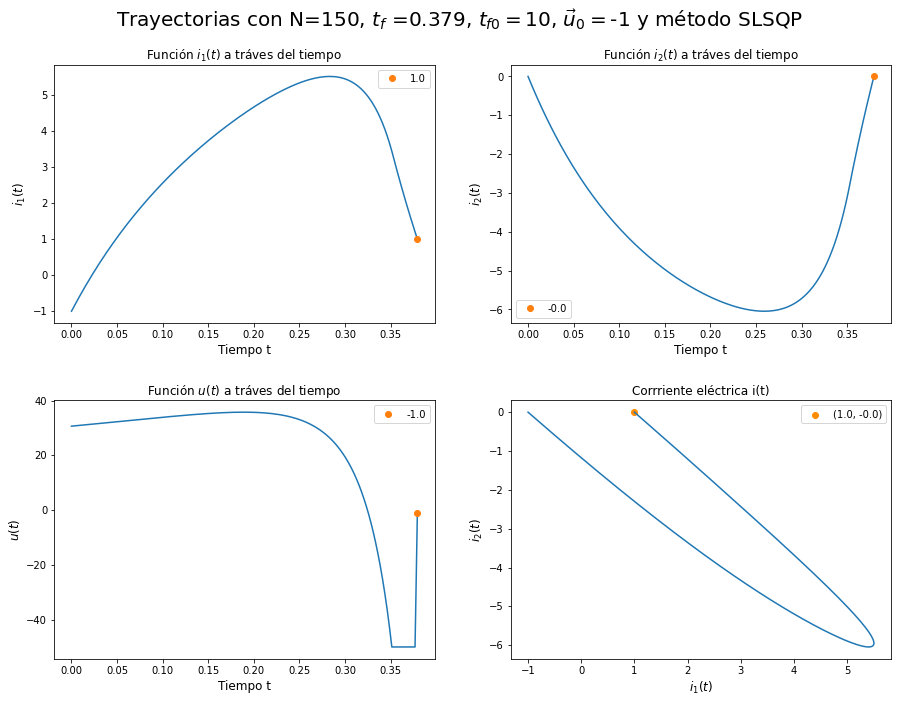

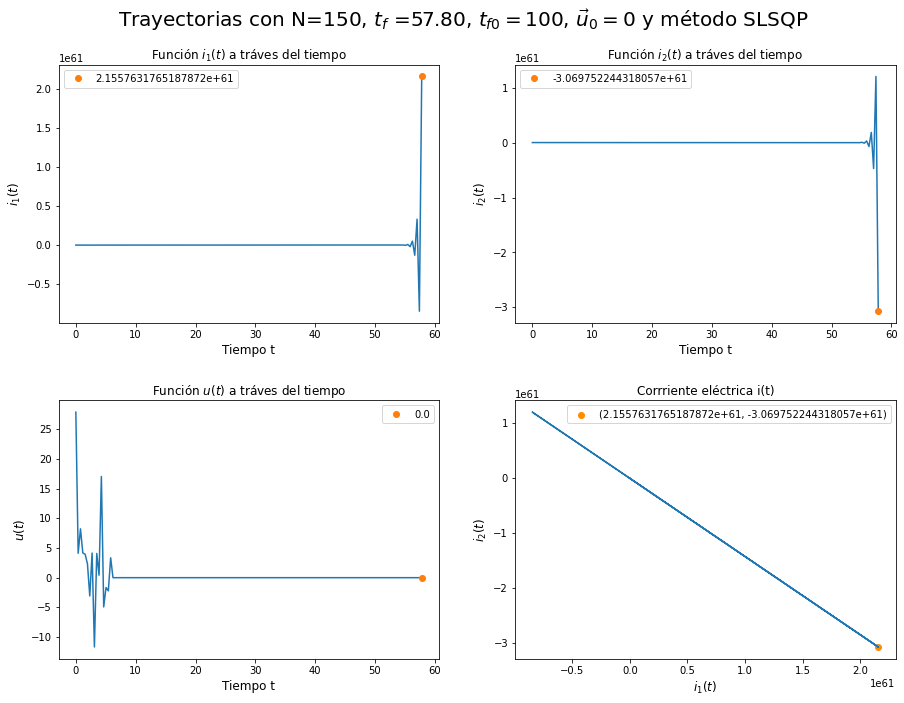

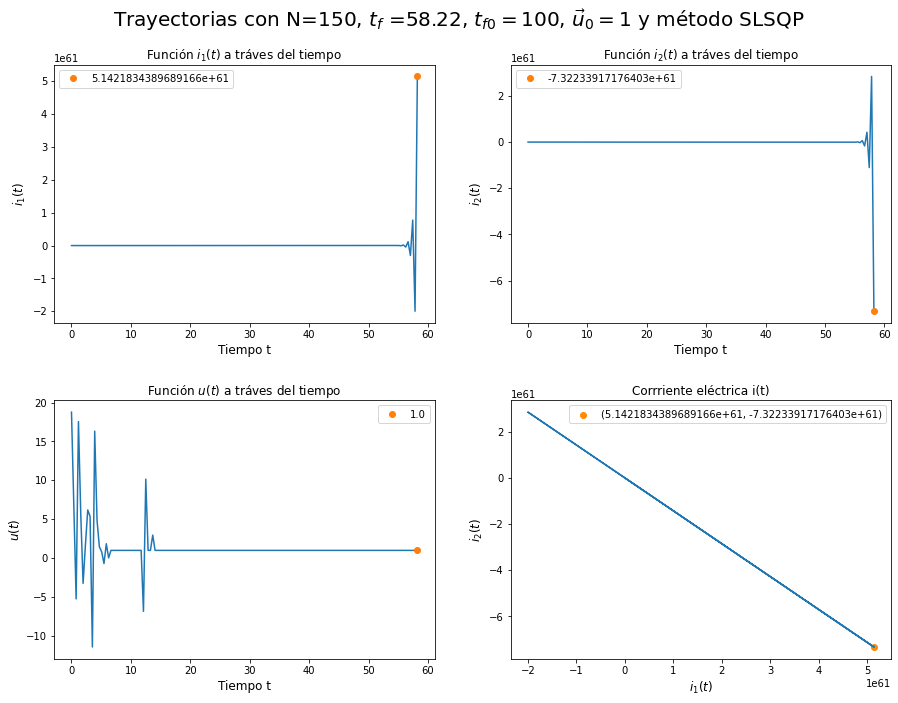

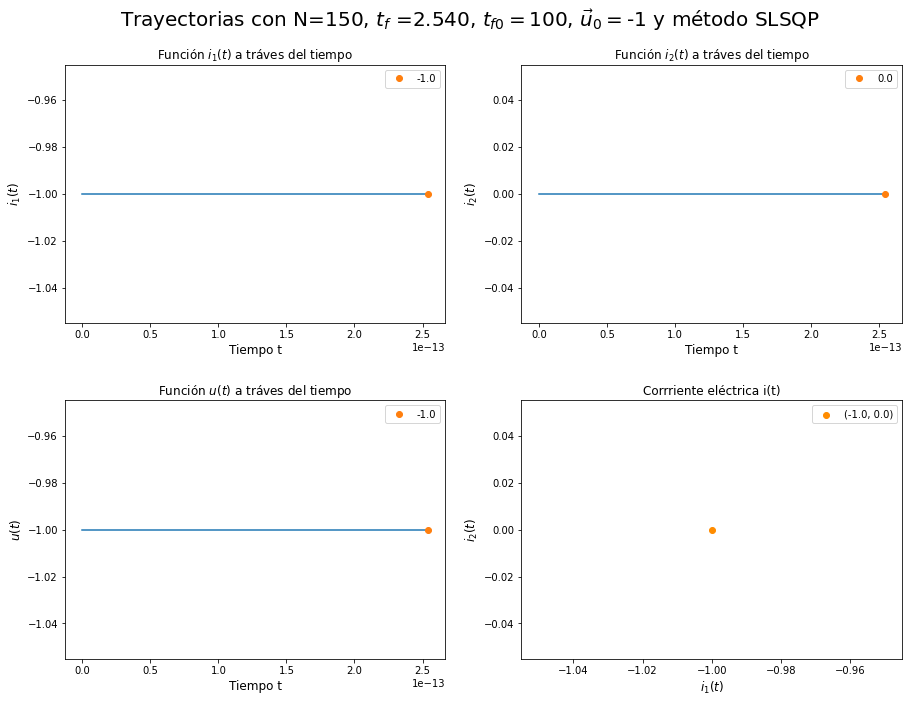

In [12]:
#Variación de las condiciones iniciales t_0 y u_0
metodo='SLSQP'
N=150
t0s=[0.1,10,100]
U0=[np.zeros(N),np.ones(N),-np.ones(N)]

for t0 in t0s:
    l=0
    t0 = np.array([t0])
    for u0 in U0:
        solucion_optima(N, metodo, u0, t0)
    l+=1

Para los parámetros escogidos, se observa que para tiempos $t_{f_{0}}$ pequeños, el control óptimo obtenido es bastante similar y conserva un una evolución bastante sueva durante todo su trayecto. Solo se observa una pequeña diferencia en el trayecto de las corrientes al variar el vector de control inicial $\vec{u}_0$. Por otro lado, para tiempos muy grandes (como 100), el problema converge a un punto que no es factible, dando como resultado trayectos erráticos tanto para el control como para la corriente eléctrica. 

## P7

En esta pregunta se crea el sistema extendido que contiene a x y p en su entrada vectorial. Con esto, se puede crear la función F pedida con los parámetros tf y h como entradas.  
La función F_aux es una función auxiliar que permite que la sintáxis de la función fsolve de scipy funcione correctamente.

In [13]:
from operator import add 
 
# Se crea el sistema extendido (i, p) de 4 dimensiones 
def sistemaExtendido(t, x): 
    m1=np.concatenate((A,np.zeros((2,2))), axis=0) 
    m2=np.concatenate((np.zeros((2,2)),-A.T), axis=0) 
    Anuevo=np.concatenate((m1,m2), axis=1) 
    Bnuevo=np.concatenate((B, np.zeros((2,1)))) 
    Bnuevo=Bnuevo.reshape(1,4)[0] 
    b_aux=np.array([0,0,B[0][0],B[1][0]]) 
    u=a*np.sign(np.matmul(b_aux, x)) 
    return np.matmul(Anuevo,x) + Bnuevo*u 
 
def F(tf, h): 
    i_inicial=[-i0, 0] # condiciones iniciales 
    p_inicial=[-1, h] 
    x_inicial = np.concatenate((i_inicial,p_inicial), axis=0) 
    t = np.linspace(0, 10, 300) # definir tiempo 
    sol1 = solve_ivp(sistemaExtendido, t_span=[0, tf], y0=x_inicial, dense_output=True) # solución  
    return [sol1.y[0][-1], sol1.y[1][-1]] 
 
def F_aux(X): # X = [tf, h] 
    res = F(X[0],X[1]) 
    return list( map(add, res, [-1,0]) ) 

root1 = fsolve(F_aux, [10,-5]) 
# La siguiente línea debería encontrar los ceros de F_aux, y así de F pero fsolve no lo resuelve correctamente y por eso está comentada
#print('Estimación primera raíz', root1)

# ejemplos de F:
print(r'Los estados finales i_1 e i_2 son: ',F(1, -10))

Los estados finales i_1 e i_2 son:  [15.767010177313933, -8.012104133588194]


## P8

Para resolver en BOCOP, se usa un sistema (dinámica) tipo:   
$\pmatrix{i_1 \\ i_2}' = \pmatrix{a_1i_1 + a_2i_2 + a_3 u \\ a_4i_1 + a_5i_2 + a_6 u}$ 

Donde estas constantes $a_i$ se calculan a continuación:

In [14]:
a1 = -M*Rc*L2 
a2 = M*alpha*np.sqrt(L1*L2)*Rw  
a3 = M*L2 
a4 = M*np.sqrt(L1*L2)*Rc*alpha 
a5 = -M*L1*Rw 
a6 =-M*K 
print('a1: ',a1)
print('a2: ',a2)
print('a3: ',a3)
print('a4: ',a4)
print('a5: ',a5)
print('a6: ',a6)

a1:  -1.503759398496241
a2:  5.371074090131126
a3:  1.503759398496241
a4:  1.7903580300437085
a5:  -7.8947368421052655
a6:  -1.7903580300437085


Las condiciones de borde son 4: 2 de tiempo inicial para $i$ y 2 de tiempo final para $p$. Por último, el criterio a optimizar es final_time, es decir, problema de tiempo mínimo.

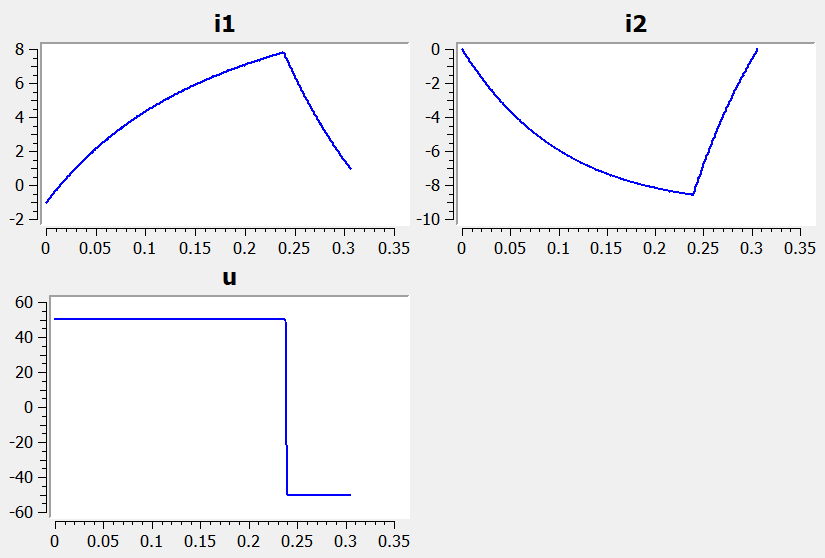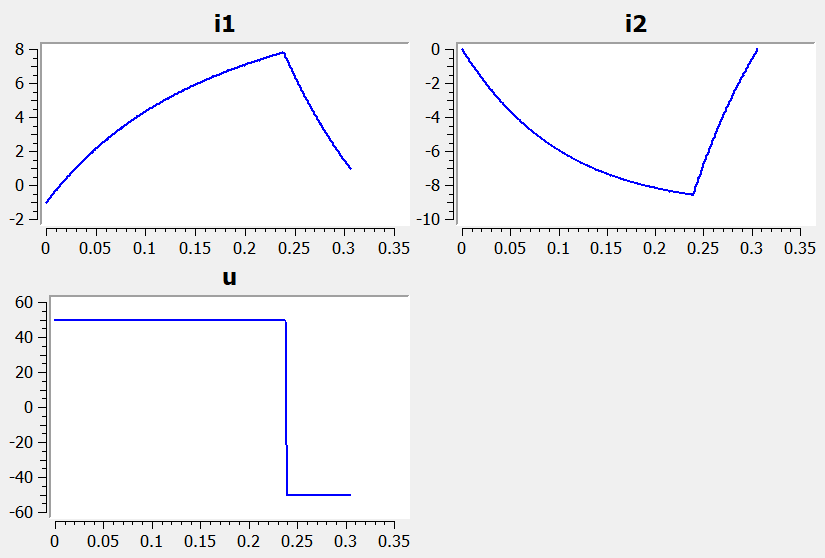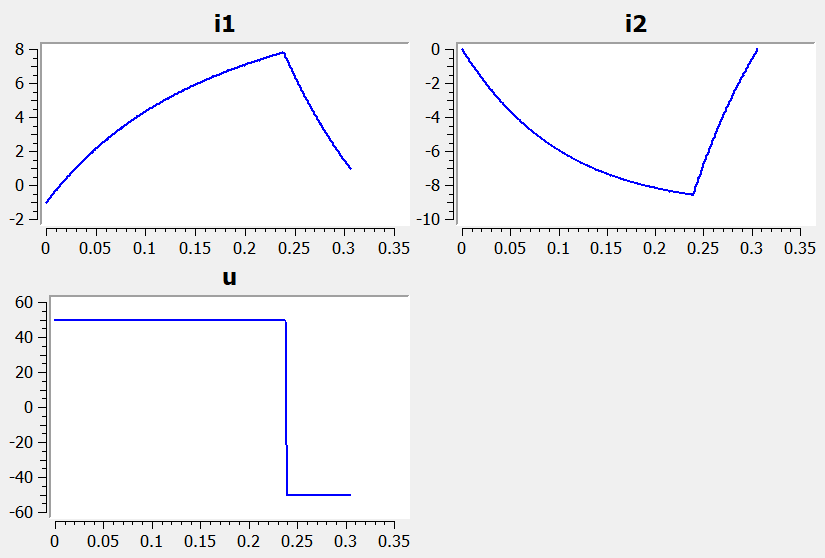

Los métodos usados fueron Midpoint, Gauss y Lobatto y sus tiempos de ejecución fueron 5.21, 12.2 y 47.37 segundos respectivamente y sus valores objetivos fueron todos 0.3 (diferenciados por muy pocas milésimas).

## P9

Para finalizar, podemos concluir que tanto la función programada en la pregunta 5 y 6 usando el método SLSQP, como el sistema programado en BOCOP nos entrega un tiempo mínimo de 0.3 con trayectorias similares tanto para el control óptimo como para la corriente eléctrica. \\
Con respecto al tiempo de ejecución, el método Midpoint de BOCOP es más rápido que SLSQP con $N$ grande.\\
Por lo tanto, en los problemas de control óptimo, BOCOP nos entrega una buena aproximación de los resultados con una rápida ejecución, de esta forma, nos ahorramos tener que plantear el sistema matricial en python y de escribir el problema de optimización, el cuál es muy sensible a los parámetros de entrada para $N$ pequeños y tarda demasiado cuando se quiere aumentar $N$ para afinar la discretización.